In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm
import random

print("--- Starting Exploratory Data Analysis (EDA) ---")

# --- 1. CONFIGURATION ---
CSV_PATH = "Pulsar Project/PULSAR_DATASET.csv"

# --- 2. LOAD DATA ---
if not os.path.exists(CSV_PATH):
    print("❌ CSV not found.")
    exit()

df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows.")

# --- HELPER: RECONSTRUCT PATHS ---
def get_image_set(row):
    """
    Takes a CSV row (Profile Path) and finds the other 3 images.
    Returns a dictionary of images.
    """
    path_profile = row['profile_path']
    base_dir = os.path.dirname(os.path.dirname(path_profile)) # Go up two levels
    filename = os.path.basename(path_profile)
    
    # The Core ID is the filename minus the suffix
    core_id = filename.replace("_Profile.png", "")
    
    features = {
        "Profile":    "_Profile.png",
        "Time_Phase": "_Time_Phase.png",
        "Freq_Phase": "_Freq_Phase.png",
        "DM_Curve":   "_DM_Curve.png"
    }
    
    img_data = {}
    for feat, suffix in features.items():
        # Construct path: Base / FeatureFolder / CoreID_Feature.png
        p = os.path.join(base_dir, feat, f"{core_id}{suffix}")
        if os.path.exists(p):
            try:
                img_data[feat] = Image.open(p).convert('L') # Convert to Grayscale
            except:
                img_data[feat] = None
        else:
            img_data[feat] = None
            
    return img_data

--- Starting Exploratory Data Analysis (EDA) ---
Loaded 1813 rows.



--- Visual Inspection: Random Positives vs Negatives ---
>>> Examples of PULSARS (Label 1):


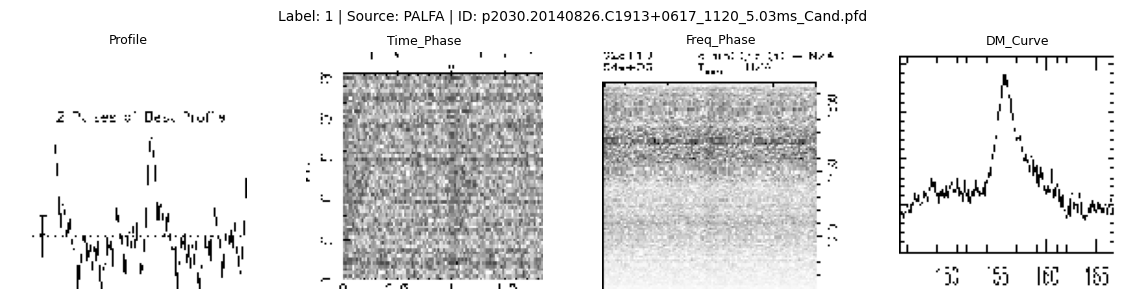

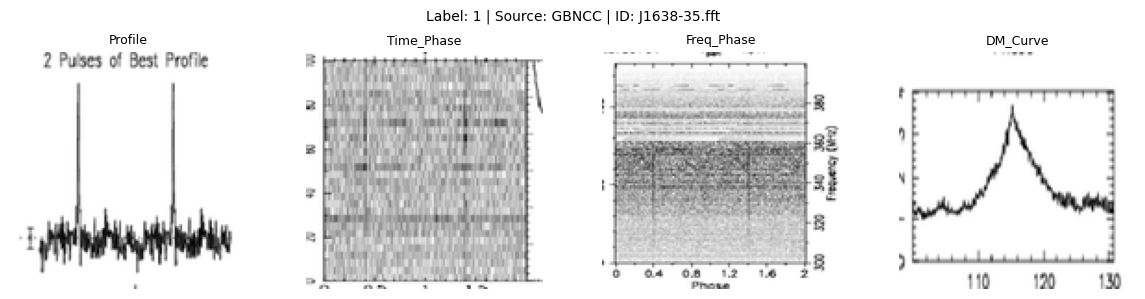

>>> Examples of NOISE (Label 0):


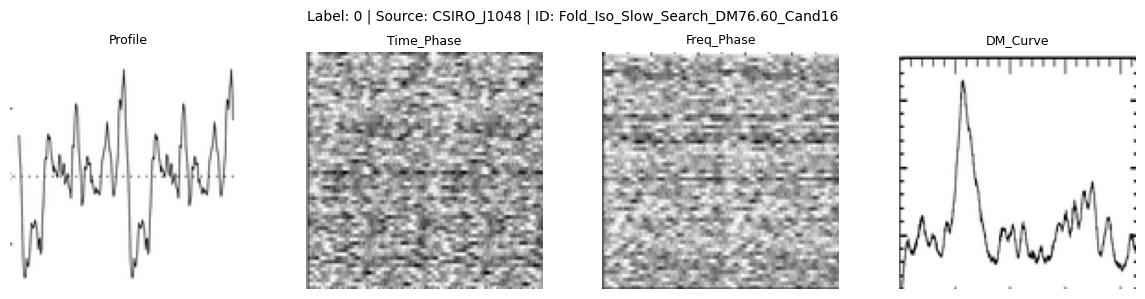

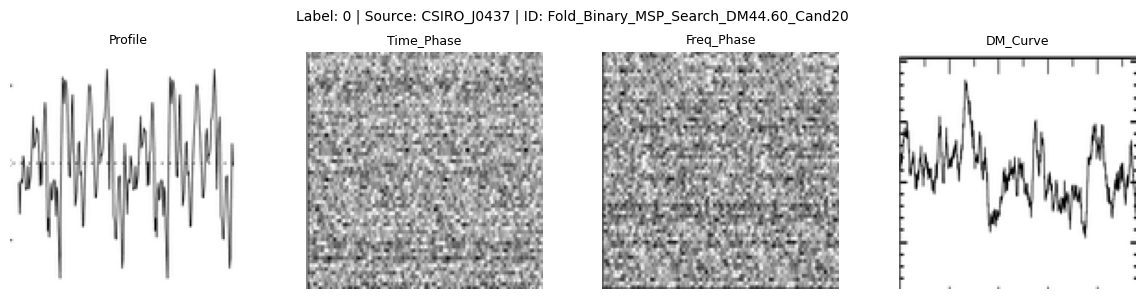

In [2]:
# ==============================================================================
# ANALYSIS 1: VISUAL INSPECTION (Random Samples)
# ==============================================================================
print("\n--- Visual Inspection: Random Positives vs Negatives ---")

def plot_samples(label_type, num=3):
    subset = df[df['label'] == label_type]
    if len(subset) == 0: return
    
    samples = subset.sample(n=min(len(subset), num), random_state=42)
    
    for _, row in samples.iterrows():
        imgs = get_image_set(row)
        
        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        order = ["Profile", "Time_Phase", "Freq_Phase", "DM_Curve"]
        
        for i, feat in enumerate(order):
            if imgs[feat]:
                axes[i].imshow(imgs[feat], cmap='gray')
                axes[i].set_title(feat, fontsize=9)
            else:
                axes[i].text(0.5, 0.5, "MISSING", ha='center')
            axes[i].axis('off')
            
        fig.suptitle(f"Label: {label_type} | Source: {row['source']} | ID: {row['filename']}", fontsize=10)
        plt.tight_layout()
        plt.show()

# Show 2 Pulsars and 2 Noise files
print(">>> Examples of PULSARS (Label 1):")
plot_samples(1, num=2)
print(">>> Examples of NOISE (Label 0):")
plot_samples(0, num=2)


--- Generating Average Images ---


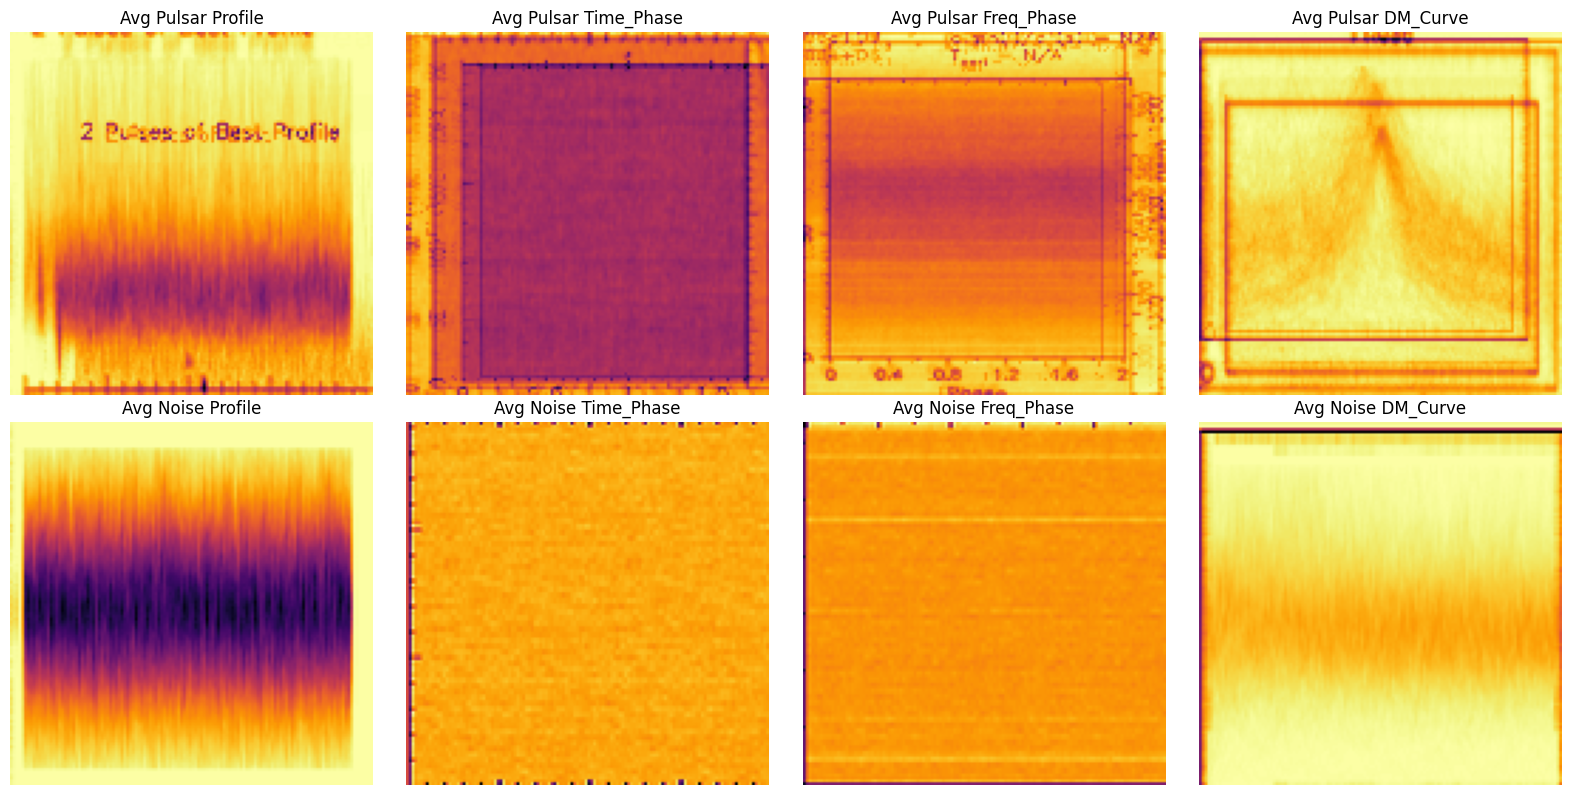

In [3]:
# ==============================================================================
# ANALYSIS 2: THE "AVERAGE FACE" (Ghost Image)
# ==============================================================================
print("\n--- Generating Average Images ---")

def get_average_image(df, label, feature="Profile"):
    subset = df[df['label'] == label]
    if len(subset) == 0: return None
    
    # Sample to speed up
    subset = subset.sample(n=min(len(subset), 500), random_state=42)
    accumulator = np.zeros((128, 128))
    count = 0
    
    for _, row in subset.iterrows():
        imgs = get_image_set(row)
        if imgs[feature]:
            # Normalize pixel values to 0-1 range
            arr = np.array(imgs[feature]) / 255.0
            # Resize if necessary (safety check)
            if arr.shape != (128, 128): continue
            accumulator += arr
            count += 1
    if count == 0: return None
    return accumulator / count

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Average Pulsar (Label 1)
features = ["Profile", "Time_Phase", "Freq_Phase", "DM_Curve"]
for i, feat in enumerate(features):
    avg_img = get_average_image(df, 1, feat)
    if avg_img is not None:
        axes[0, i].imshow(avg_img, cmap='inferno')
        axes[0, i].set_title(f"Avg Pulsar {feat}")
    axes[0, i].axis('off')

# Row 2: Average Noise (Label 0)
for i, feat in enumerate(features):
    avg_img = get_average_image(df, 0, feat)
    if avg_img is not None:
        axes[1, i].imshow(avg_img, cmap='inferno')
        axes[1, i].set_title(f"Avg Noise {feat}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


--- Checking for Domain Gap (Brightness) ---


100%|███████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.89it/s]


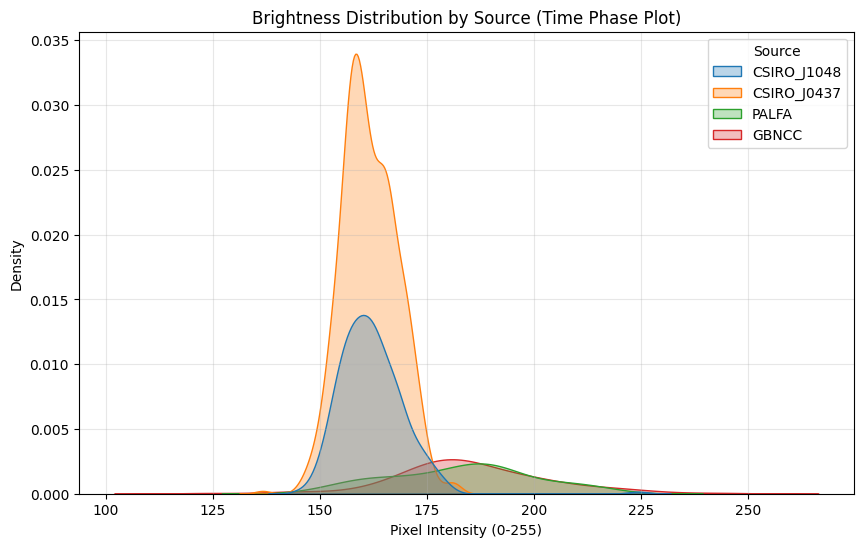

In [4]:
# ==============================================================================
# ANALYSIS 3: DOMAIN GAP (Brightness Histograms)
# ==============================================================================
print("\n--- Checking for Domain Gap (Brightness) ---")

brightness_stats = []
sample_df = df.sample(min(len(df), 1000), random_state=42)

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    imgs = get_image_set(row)
    if imgs["Time_Phase"]:
        arr = np.array(imgs["Time_Phase"])
        mean_val = np.mean(arr)
        brightness_stats.append({
            "Source": row['source'],
            "Label": str(row['label']),
            "Mean_Brightness": mean_val
        })
b_df = pd.DataFrame(brightness_stats)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=b_df, x="Mean_Brightness", hue="Source", fill=True, alpha=0.3)
plt.title("Brightness Distribution by Source (Time Phase Plot)")
plt.xlabel("Pixel Intensity (0-255)")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
print("\n--- Numerical Brightness Analysis by Source and Label ---")

# Ensure b_df (Brightness DataFrame) is created as in your previous script
# This assumes b_df has columns: 'Source', 'Label', 'Mean_Brightness'

# Calculate descriptive statistics
stats_summary = b_df.groupby(['Source', 'Label'])['Mean_Brightness'].agg(
    ['count', 'mean', 'std', 'min', 'max']
).reset_index()

# Rename columns for clarity
stats_summary.columns = ['Source', 'Label', 'Count', 'Avg_Brightness', 'Std_Dev', 'Min', 'Max']

# Sort for better readability
stats_summary = stats_summary.sort_values(by=['Source', 'Label'])

print(stats_summary.to_string(index=False))

# Optional: Calculate the "Domain Gap"
# (Difference between PALFA/GBNCC and CSIRO brightness)
overall_source_avg = b_df.groupby('Source')['Mean_Brightness'].mean()
print("\n--- Average Brightness per Source (Domain Check) ---")
print(overall_source_avg)


--- Numerical Brightness Analysis by Source and Label ---
     Source Label  Count  Avg_Brightness   Std_Dev        Min        Max
CSIRO_J0437     0    534      161.537169  6.488860 136.649902 181.875061
CSIRO_J0437     1     12      161.899541  5.664578 148.595337 169.062744
CSIRO_J1048     0    240      162.058009  7.693559 145.531982 224.370117
CSIRO_J1048     1      9      161.771776  7.779002 152.411438 173.873230
      GBNCC     1    105      185.445929 18.414261 123.697083 244.709045
      PALFA     1    100      183.111931 16.819913 147.088684 219.421143

--- Average Brightness per Source (Domain Check) ---
Source
CSIRO_J0437    161.545133
CSIRO_J1048    162.047663
GBNCC          185.445929
PALFA          183.111931
Name: Mean_Brightness, dtype: float64


Loading samples...


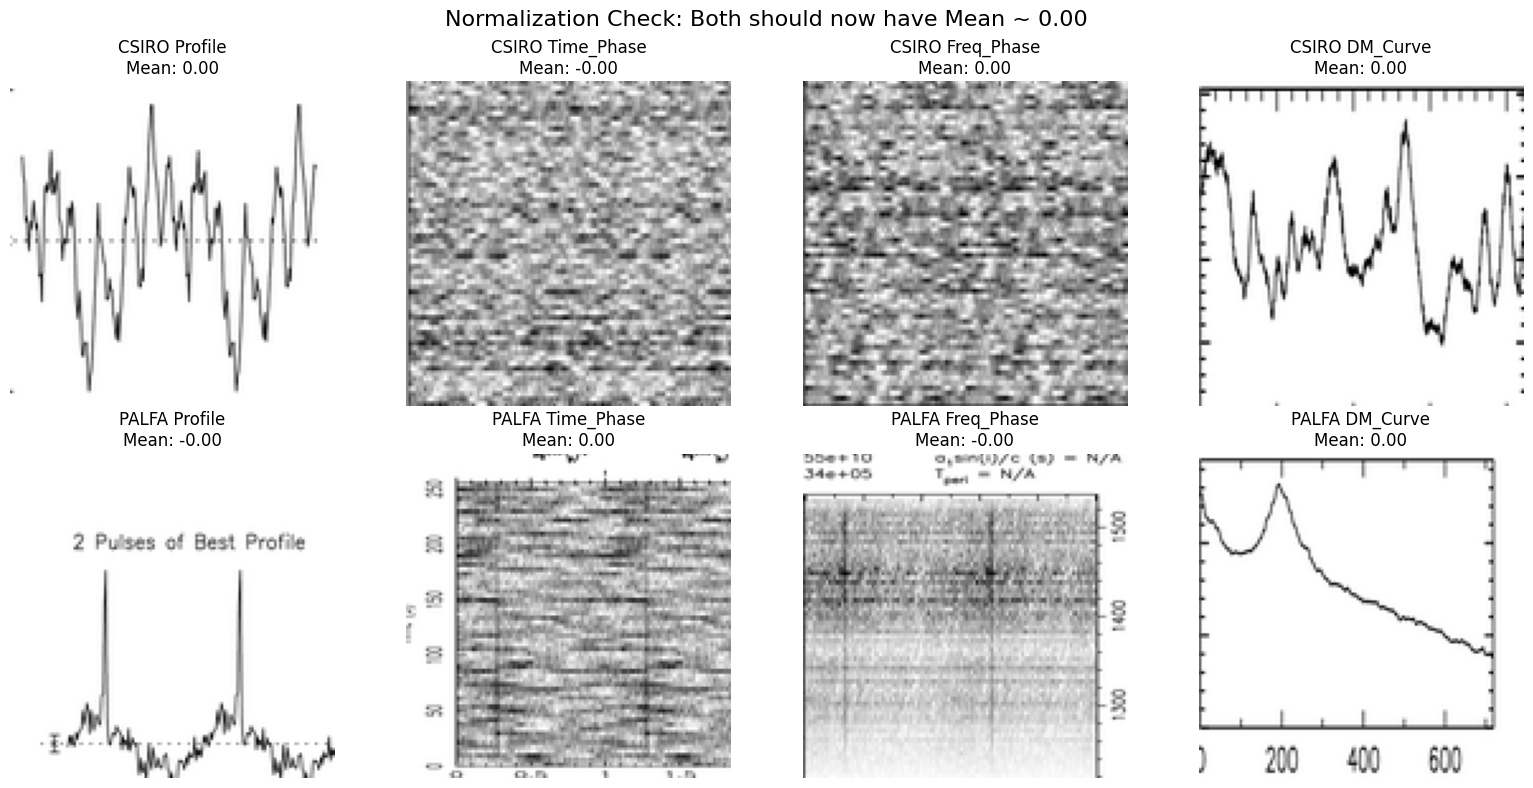

In [6]:
# --- CONFIGURATION ---
CSV_PATH = "PULSAR_DATASET.csv"

def load_and_normalize(row):
    """
    Loads 4 images, converts to Grayscale, and applies Z-Score Normalization.
    """
    # 1. Reconstruct Paths
    # We know the profile_path is in the CSV. We infer the others.
    path_profile = row['profile_path']
    base_dir = os.path.dirname(os.path.dirname(path_profile)) # Go up to candidate folder
    filename = os.path.basename(path_profile)
    core_id = filename.replace("_Profile.png", "")
    
    features = ["Profile", "Time_Phase", "Freq_Phase", "DM_Curve"]
    processed_images = {}
    
    for feat in features:
        # Construct path: .../FeatureName/CoreID_FeatureName.png
        p = os.path.join(base_dir, feat, f"{core_id}_{feat}.png")
        
        if os.path.exists(p):
            # A. Open & Grayscale
            img = Image.open(p).convert('L') 
            
            # B. Convert to Numpy Array (0 to 255)
            arr = np.array(img).astype(np.float32)
            
            # C. Per-Image Normalization (The Fix for Domain Gap)
            # Formula: (Pixel - Mean) / StdDev
            # This forces every image to be centered at 0 with similar contrast.
            mean = np.mean(arr)
            std = np.std(arr)
            
            # Avoid division by zero if image is blank
            if std > 0:
                norm_arr = (arr - mean) / std
            else:
                norm_arr = arr - mean
                
            processed_images[feat] = norm_arr
        else:
            print(f"Missing: {p}")
            return None # Skip broken files

    return processed_images

# --- EXECUTION ---
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    
    # Let's test it on one CSIRO image and one PALFA image to see if they look similar now
    print("Loading samples...")
    
    # Get one random row from each source
    sample_csiro = df[df['source'].str.contains("CSIRO")].sample(1).iloc[0]
    sample_palfa = df[df['source'] == "PALFA"].sample(1).iloc[0]
    
    imgs_csiro = load_and_normalize(sample_csiro)
    imgs_palfa = load_and_normalize(sample_palfa)
    
    # --- PLOTTING TO VERIFY NORMALIZATION ---
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    features = ["Profile", "Time_Phase", "Freq_Phase", "DM_Curve"]
    
    # Row 1: CSIRO (Originally Darker)
    for i, feat in enumerate(features):
        im = axes[0, i].imshow(imgs_csiro[feat], cmap='gray')
        axes[0, i].set_title(f"CSIRO {feat}\nMean: {np.mean(imgs_csiro[feat]):.2f}")
        axes[0, i].axis('off')
        
    # Row 2: PALFA (Originally Brighter)
    for i, feat in enumerate(features):
        im = axes[1, i].imshow(imgs_palfa[feat], cmap='gray')
        axes[1, i].set_title(f"PALFA {feat}\nMean: {np.mean(imgs_palfa[feat]):.2f}")
        axes[1, i].axis('off')
        
    plt.suptitle("Normalization Check: Both should now have Mean ~ 0.00", fontsize=16)
    plt.tight_layout()
    plt.show()
    
else:
    print("CSV not found.")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import os

print("--- Step 1: Performing Safe Train/Val/Test Split ---")

# --- CONFIGURATION ---
OUTPUT_DIR = os.path.dirname(CSV_PATH)

# Ratios
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# --- EXECUTION ---
if not os.path.exists(CSV_PATH):
    print("❌ CSV not found.")
else:
    df = pd.read_csv(CSV_PATH)
    
    # 1. Split Train vs (Val + Test)
    # We split based on 'group_id' so duplicates stay together
    splitter_1 = GroupShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, random_state=42)
    train_idx, temp_idx = next(splitter_1.split(df, groups=df['group_id']))
    
    train_df = df.iloc[train_idx]
    temp_df = df.iloc[temp_idx]
    
    # 2. Split (Val + Test) into Val and Test
    # Adjust ratio: If we want 15% total for val, that's 50% of the remaining 30%
    splitter_2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
    val_idx, test_idx = next(splitter_2.split(temp_df, groups=temp_df['group_id']))
    
    val_df = temp_df.iloc[val_idx]
    test_df = temp_df.iloc[test_idx]
    
    # --- STATISTICS ---
    print(f"\nTotal Rows: {len(df)}")
    print("-" * 30)
    print(f"Train Set: {len(train_df)} rows")
    print(f"   Positives: {len(train_df[train_df['label']==1])}")
    print(f"   Negatives: {len(train_df[train_df['label']==0])}")
    
    print("-" * 30)
    print(f"Val Set:   {len(val_df)} rows")
    print(f"   Positives: {len(val_df[val_df['label']==1])}")
    
    print("-" * 30)
    print(f"Test Set:  {len(test_df)} rows")
    print(f"   Positives: {len(test_df[test_df['label']==1])}")
    print(f"   Negatives: {len(test_df[test_df['label']==0])}")
    
    # --- SAVE ---
    train_df.to_csv(os.path.join(OUTPUT_DIR, "train_dataset.csv"), index=False)
    val_df.to_csv(os.path.join(OUTPUT_DIR, "val_dataset.csv"), index=False)
    test_df.to_csv(os.path.join(OUTPUT_DIR, "test_dataset.csv"), index=False)
    
    print(f"\n✅ Splits saved ")

--- Step 1: Performing Safe Train/Val/Test Split ---


NameError: name 'CSV_PATH' is not defined

✅ Loading Index 0 | Label: 0.0


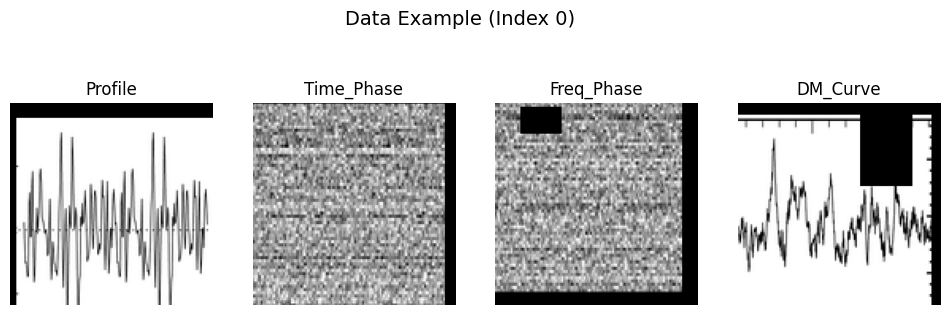

Data Loader created!


In [1]:
# 1. Import your custom module
import pulsar_augmentation 
from torch.utils.data import DataLoader

# 2. Define your CSV path
train_csv_path = "train_dataset.csv"

# 3. Get the Transforms (Train = Messy, Test = Clean)
train_t, test_t = pulsar_augmentation.get_transforms(img_size=128)

# 4. Visualize to make sure it works
# This replaces that long block of plotting code you had before
pulsar_augmentation.show_example(train_csv_path, transform=train_t, index=0)

# Create the Dataset Object using your class
train_ds = pulsar_augmentation.PulsarDataset(csv_file=train_csv_path, transform=train_t)

# Create the Loader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

print("Data Loader created!")

⚙️ forcing device: cpu (to bypass CUDA/GPU compatibility issues)
🚀 Training starting on cpu...


Epoch 1/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [02:11<00:00,  3.21s/it]


    Train Loss: 0.5662 | Acc: 0.7861
    Val   Loss: 0.1571 | Acc: 0.9470


Epoch 2/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:34<00:00,  2.30s/it]


    Train Loss: 0.2621 | Acc: 0.9329
    Val   Loss: 0.0386 | Acc: 0.9886


Epoch 3/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:40<00:00,  2.44s/it]


    Train Loss: 0.2206 | Acc: 0.9469
    Val   Loss: 0.0473 | Acc: 0.9811


Epoch 4/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:35<00:00,  2.34s/it]


    Train Loss: 0.1782 | Acc: 0.9578
    Val   Loss: 0.0106 | Acc: 1.0000


Epoch 5/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:42<00:00,  2.50s/it]


    Train Loss: 0.1820 | Acc: 0.9563
    Val   Loss: 0.0145 | Acc: 1.0000


Epoch 6/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:34<00:00,  2.30s/it]


    Train Loss: 0.1690 | Acc: 0.9610
    Val   Loss: 0.0220 | Acc: 1.0000


Epoch 7/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:00<00:00,  1.47s/it]


    Train Loss: 0.1484 | Acc: 0.9633
    Val   Loss: 0.0125 | Acc: 0.9962


Epoch 8/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:00<00:00,  1.48s/it]


    Train Loss: 0.1633 | Acc: 0.9625
    Val   Loss: 0.0353 | Acc: 1.0000


Epoch 9/15 [Train]: 100%|███████████████████████████████████████████| 41/41 [01:01<00:00,  1.49s/it]


    Train Loss: 0.1560 | Acc: 0.9633
    Val   Loss: 0.0157 | Acc: 1.0000


Epoch 10/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [01:07<00:00,  1.64s/it]


    Train Loss: 0.1550 | Acc: 0.9657
    Val   Loss: 0.0054 | Acc: 1.0000


Epoch 11/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [01:11<00:00,  1.75s/it]


    Train Loss: 0.1493 | Acc: 0.9688
    Val   Loss: 0.0098 | Acc: 1.0000


Epoch 12/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [01:01<00:00,  1.51s/it]


    Train Loss: 0.1394 | Acc: 0.9664
    Val   Loss: 0.0031 | Acc: 1.0000


Epoch 13/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [01:05<00:00,  1.59s/it]


    Train Loss: 0.1446 | Acc: 0.9688
    Val   Loss: 0.0123 | Acc: 1.0000


Epoch 14/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [01:08<00:00,  1.68s/it]


    Train Loss: 0.1479 | Acc: 0.9696
    Val   Loss: 0.0139 | Acc: 1.0000


Epoch 15/15 [Train]: 100%|██████████████████████████████████████████| 41/41 [00:59<00:00,  1.45s/it]


    Train Loss: 0.1329 | Acc: 0.9664
    Val   Loss: 0.0055 | Acc: 1.0000


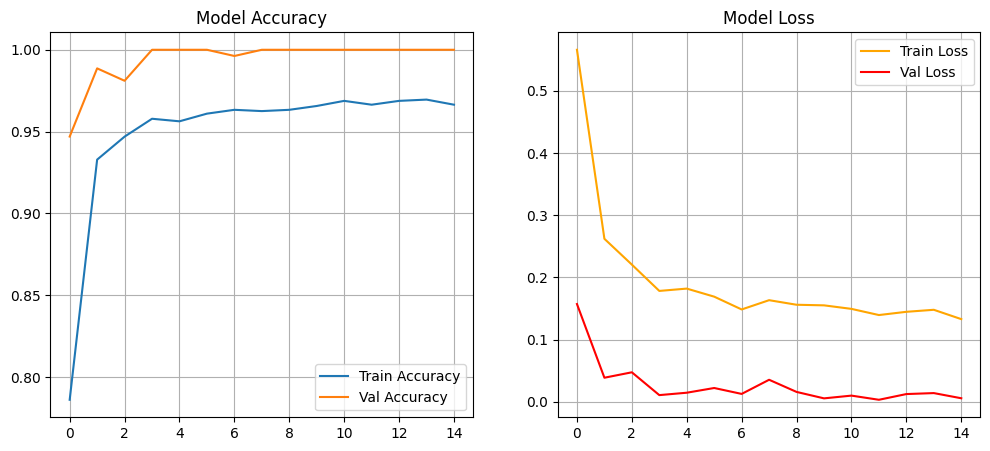


--- Final Evaluation on Test Set ---


Predicting: 100%|█████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/it]


🏆 FINAL TEST RESULTS 🏆
Accuracy:  0.9963
Precision: 0.9808
Recall:    1.0000
F1-Score:  0.9903

Confusion Matrix:
True Negatives: 216 | False Positives: 1
False Negatives: 0 | True Positives:  51


In [2]:
# 1. Import your custom module
import pulsar_train

# 2. Define Paths
TRAIN_CSV = "train_dataset.csv"
VAL_CSV   = "val_dataset.csv"
TEST_CSV  = "test_dataset.csv"

# 3. Train the Model
# This will run the loops, print progress, and pop up the graphs automatically.
trained_model = pulsar_train.train_model(
    train_csv=TRAIN_CSV, 
    val_csv=VAL_CSV, 
    epochs=15, 
    batch_size=32, 
    lr=0.001
)
# 4. Evaluate on Test Data
pulsar_train.evaluate_model(trained_model, TEST_CSV)